# IMDB-WIKI
##  Multi-task age and gender classification

On the original paper [DEX: Deep EXpectation of apparent age from a single image](https://www.vision.ee.ethz.ch/en/publications/papers/proceedings/eth_biwi_01229.pdf) the authors were able to display remarkable results in classifying the age of an individual based on a given image alone. 

Let see how accuracy (bad I guess), with limited resources, we can get with self-construct architecture. And not only age, we also classifying gender by using multi-task training technique.

In [4]:
import os
from six.moves import cPickle as pickle
import numpy as np
import scipy.io as sio
import scipy.misc as spm
from scipy import ndimage
import datetime
import matplotlib.image as plt
from IPython.display import Image, display
%matplotlib inline
import numpy as np
import pandas as pd
from scipy import stats, integrate
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
from collections import Counter
# from skimage.transform import resize

IMG_DIR = r'/home/ubuntu/coding/cnn/datasets/imdb_crop'
MAT_FILE = r'/home/ubuntu/coding/cnn/datasets/imdb_crop/imdb.mat'

First, the labels, which was not easily obtained. The meta data is stored separately and in a .mat file. (Yes, matlab)!

The age parameter, requires us to calculate by taking the ```photo_taken``` and subtracting the ```dob```, the date of birth. Sounds easy? No ... as the dob is stored as a Matlab serial number.

Luckily we can use the ```scipy.io.loadmat``` to load the ```.mat``` file to python accessible (kind of) format. We can access the ```dob``` by some proper indexing, and convert the Matlab serial number to a usable format by using ```datetime.date.fromordinal( serial_number ).year```.

In [5]:
def reformat_date(mat_date):
    dt = datetime.date.fromordinal(np.max([mat_date - 366, 1])).year
    return dt

In [6]:
def create_path(path):
    return os.path.join(IMG_DIR, path[0])

In [7]:
mat_struct = sio.loadmat(MAT_FILE)
data_set = [data[0] for data in mat_struct['imdb'][0, 0]]

keys = ['dob',
    'photo_taken',
    'full_path',
    'gender',
    'name',
    'face_location',
    'face_score',
    'second_face_score',
    'celeb_names',
    'celeb_id'
]

imdb_dict = dict(zip(keys, np.asarray(data_set)))
imdb_dict['dob'] = [reformat_date(dob) for dob in imdb_dict['dob']]
imdb_dict['full_path'] = [create_path(path) for path in imdb_dict['full_path']]

# Add 'age' key to the dictionary
imdb_dict['age'] = imdb_dict['photo_taken'] - imdb_dict['dob']

print("Dictionary created...")

Dictionary created...


The IMDB dataset has total 460,723 face images from 20,284 celebrities. 

We will ignore:
* images with more than one face
* gender is NaN
* invalid age.

As we are using only a subset of the data, and also using a self-constructed model that has a much smaller capacity, thus we need to take steps to adjust accordingly.

The original paper uses 101 age classes, which was appropriate for the their data set size and learning architecture. As we are only using a small subset of the data and a very simple model, the number of classes was set to 4:
* Young    (30yrs < age)
* Middle   (30 <= age <45)
* Old      (45 <= age < 60)
* Very Old (60 <= age)

In [8]:
raw_path = imdb_dict['full_path']
raw_age = imdb_dict['age']
raw_gender = imdb_dict['gender']
raw_sface = imdb_dict['second_face_score']

age = []
gender = []
imgs = []
current_age = {0:0, 1:0, 2:0, 3:0}
for i, sface in enumerate(raw_sface):
    if i%50000==0:
        print("Processing {0} of {1}".format(i,len(raw_sface)))
#         display(Image(filename=raw_path[i]))
        print("Second face score: {}".format(sface))
        print("Age: {}".format(raw_age[i]))
        print("Gender: {}".format(raw_gender[i]))
    if np.isnan(sface) and raw_age[i] >= 0 and not np.isnan(raw_gender[i]):
        age_tmp = 0;
        if len(age) == 170000:
            break
        if raw_age[i] < 30 and current_age[0] < 42500:
            current_age[0] += 1
            age_tmp = 0
        elif raw_age[i] <= 45 and current_age[1] < 69923:
            current_age[1] += 1
            age_tmp = 1
        elif raw_age[i] < 60 and current_age[2] < 42500:
            current_age[2] += 1
            age_tmp = 2
        elif raw_age[i] >= 60 and current_age[3] < 42500:
            current_age[3] += 1
            age_tmp = 3
        else:
            continue
        age.append(age_tmp)
        gender.append(raw_gender[i])
        imgs.append(raw_path[i])

Processing 0 of 460723
Second face score: 1.1189733571573068
Age: 69
Gender: 1.0
Processing 50000 of 460723
Second face score: 1.6382603784375749
Age: 62
Gender: 1.0
Processing 100000 of 460723
Second face score: nan
Age: 48
Gender: 1.0
Processing 150000 of 460723
Second face score: nan
Age: 45
Gender: 0.0
Processing 200000 of 460723
Second face score: nan
Age: 55
Gender: 1.0
Processing 250000 of 460723
Second face score: 3.7557645554368593
Age: 35
Gender: 1.0
Processing 300000 of 460723
Second face score: 1.4490431053500914
Age: 27
Gender: 0.0
Processing 350000 of 460723
Second face score: nan
Age: 24
Gender: 1.0
Processing 400000 of 460723
Second face score: nan
Age: 27
Gender: 0.0
Processing 450000 of 460723
Second face score: 2.408505783400527
Age: 31
Gender: 0.0


{0: 42500, 1: 69923, 2: 42500, 3: 15077}


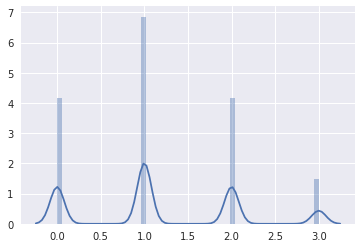

In [9]:
print(current_age)
sns.distplot(age);
# current_age

In [10]:
pickle_file = 'imdb-age-gender.pkl'

try:
    f = open(os.getcwd()+"/pkl_folder/"+pickle_file, 'wb')
    save = {
    'age': age,
    'gender': gender,
    'imgs': imgs
    }
    pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
    f.close()
except Exception as e:
    print('Unable to save data to', pickle_file, ':', e)
    raise